In [105]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
from math import log

import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from typing import Tuple
 
stop_words = set(stopwords.words('english')) 
# nltk.download()


In [1]:
punctuation = set(""",';][=-`?><":}{+_~!@#$#%^&*()\\|}"]'""")
punctuation.add("''")
punctuation.add("``")


def tokenize(text, stem=True, remove_stopwords=True, remove_punctuation=True):
    tokens = nltk.word_tokenize(text)
    
    if stem:
        tokens = [PorterStemmer().stem(item) for item in tokens]
        
    if remove_stopwords:
        tokens = [tok for tok in tokens if tok not in stop_words]
        
    # TAG HERE, before punctuation removal.
        
    if remove_punctuation:
        tokens = [tok for tok in tokens if tok not in punctuation]
        
    return tokens

In [23]:
filename = 'MovieReviewsMPJ.csv'

rawdata = pd.read_csv(filename)
target = 'score'

In [45]:
def partition_data(data: pd.DataFrame, train_ration: float, validation_ratio: float, test_ratio: float):
    train_valid, test = train_test_split(data, test_size=test_ratio)
    train, valid = train_test_split(train_valid, test_size=(validation_ratio/(validation_ratio+train_ration)))
    
    return train, valid, test

In [52]:
rawdata.score.value_counts()

5    6174
4    2333
3    1161
1     805
2     638
Name: score, dtype: int64

In [46]:
# splits = (train, validate, test)
splits = (0.6, 0.2, 0.2)

In [89]:
train, valid, test = partition_data(rawdata, 0.15, 0.1, 0.75)

In [90]:
print('\n'.join(round(train.score.value_counts() / train.shape[0] * 100, 2).sort_index().astype(str).to_list()))

6.78
6.18
10.14
21.73
55.16


In [91]:
print('\n'.join(round(valid.score.value_counts() / valid.shape[0] * 100, 2).sort_index().astype(str).to_list()))

6.66
6.21
10.26
20.7
56.17


In [92]:
print('\n'.join(round(test.score.value_counts() / test.shape[0] * 100, 2).sort_index().astype(str).to_list()))

7.42
5.59
10.54
20.89
55.57


In [106]:
pos_tokens = [pos_tag(tokenize(text), tagset='universal') for text in rawdata.text]

In [108]:
counted_pos_tokens = [dict(Counter(tokens)) for tokens in pos_tokens]

In [109]:
pos_frame = pd.DataFrame(counted_pos_tokens)

In [110]:
N = pos_frame.shape[0]
num_docs = pos_frame.notnull().sum()

doc_length = [len(tokens) for tokens in pos_tokens]

In [117]:
tfidf_data = list()
for n in range(len(pos_frame)):
    doc = pos_frame.iloc[n]
    term, pos = list(zip(*doc.index))
    log2 = lambda x: log(x, 2)

    tfidf_df = pd.DataFrame(data={'pos': pos, 
                                  'freq': map(int, doc.fillna(0).tolist()),
                                  'numdocs': num_docs.tolist()},            
                            index=term).sort_values('freq', ascending=False)

    tfidf_df['tokens_in_doc'] = doc_length[n]
    tfidf_df['weigthed_tf'] = 0.5 + 0.5 * tfidf_df['freq'] / tfidf_df['freq'].max()

    tfidf_df['idf'] = (N / tfidf_df['numdocs']).apply(log2)
    tfidf_df['tfidf'] = tfidf_df['freq'] * tfidf_df['idf']

    tfidf_df['weigthed_tfidf'] = tfidf_df['weigthed_tf'] * tfidf_df['idf']

    tfidf_data.append(tfidf_df['tfidf'].to_dict())

In [128]:
tfidf_frame = pd.DataFrame(tfidf_data)

In [129]:
tfidf_frame.index = 'document_' + tfidf_frame.index.astype(str)

In [130]:
tfidf_frame.head()

,br,juarez,I,minni,worker,stigmata,appear,also,driver,messag,...,b000gfri4k,.mr,outdor,overabund,ingrient,intracasi,peal,hoof,grandkid,heyricki
document_0,0.0,0.000000,1.550793,22.879402,17.065621,23.709477,0.0,4.766127,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
document_1,0.0,0.000000,0.000000,11.439701,0.000000,11.854739,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
document_2,0.0,0.000000,1.550793,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
document_3,0.0,13.439701,1.033862,11.439701,0.000000,11.854739,0.0,7.149190,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
document_4,0.0,0.000000,0.000000,0.000000,8.532810,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
tfidf_df[tfidf_df.freq.gt(0)].sort_values('tfidf', ascending=False).head(10)

,pos,freq,numdocs,tokens_in_doc,weigthed_tf,idf,tfidf,weigthed_tfidf
51,NUM,3,13,170,0.8,9.739261,29.217784,7.791409
groups.,NOUN,2,1,170,0.7,13.439701,26.879402,9.407791
pre-record,ADJ,2,1,170,0.7,13.439701,26.879402,9.407791
doo,VERB,2,2,170,0.7,12.439701,24.879402,8.707791
egrav,X,2,3,170,0.7,11.854739,23.709477,8.298317
cheer,NOUN,3,62,170,0.8,7.485505,22.456514,5.988404
wop,NOUN,2,6,170,0.7,10.854739,21.709477,7.598317
amp,NOUN,2,59,170,0.7,7.557058,15.114116,5.289941
limelit,NOUN,1,1,170,0.6,13.439701,13.439701,8.063821
parri,ADJ,1,1,170,0.6,13.439701,13.439701,8.063821


In [304]:
len(tfidf_df)

66030

In [149]:
all_text = ' '.join(rawdata.text.tolist())
words = nltk.word_tokenize(all_text)

words = [word for word in words if word not in stop_words.union(punctuation)]

In [323]:
tfidf_df[tfidf_df.freq.gt(0)].sort_values('tfidf', ascending=False).tail(30)

,pos,freq,numdocs,tokens_in_doc,weigthed_tf,idf,tfidf,weigthed_tfidf
stori,VERB,1,435,188,0.583333,4.674829,4.674829,2.726984
enough,ADJ,1,438,188,0.583333,4.664914,4.664914,2.721200
perfect,ADJ,1,451,188,0.583333,4.622717,4.622717,2.696585
girl,NOUN,1,477,188,0.583333,4.541856,4.541856,2.649416
rather,ADV,1,546,188,0.583333,4.346944,4.346944,2.535717
name,NOUN,1,558,188,0.583333,4.315580,4.315580,2.517422
least,ADJ,1,559,188,0.583333,4.312997,4.312997,2.515915
releas,NOUN,1,572,188,0.583333,4.279830,4.279830,2.496567
view,NOUN,1,605,188,0.583333,4.198910,4.198910,2.449364
around,ADP,1,669,188,0.583333,4.053839,4.053839,2.364739


In [151]:
import nltk.collocations
import nltk.corpus
import collections

bgm    = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(words)
scored = finder.score_ngrams( bgm.likelihood_ratio  )

# Group bigrams by first word in bigram.                                        
prefix_keys = collections.defaultdict(list)
for key, scores in scored:
    prefix_keys[key[0]].append((key[1], scores))

# Sort keyed bigrams by strongest association.                                  
for key in prefix_keys:
    prefix_keys[key].sort(key = lambda x: -x[1])

In [ ]:
word = 'fever'

print(word, prefix_keys[word][:5])

In [290]:
import networkx as nx
from matplotlib import pyplot as plt

def build_graph(word, n=10):
    g = nx.Graph()
    g.add_node(word)
    g.add_nodes_from([co_word for co_word, score in prefix_keys[word][:n]])
    for co_word, score in prefix_keys[word][:n]:
        edge = (word, co_word)
        g.add_edge(*edge)
        g[edge[0]][edge[1]]['score'] = score
    
        
    return g

def draw_graph(g):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    pos = nx.spring_layout(g)


    
    widths = [g.get_edge_data(*e)['score'] for e in g.edges()]
    maxwidth = 10
    widths = [w/max(widths)*maxwidth for w in widths]
    nx.draw_networkx_edges(g, 
                           pos,
                           edgelist=list(g.edges),
                           width=widths, 
                           alpha=0.2, edge_color='k')
    
    # nodes
    nx.draw_networkx_nodes(g, pos,
                           nodelist=list(g.nodes),
                           node_color='lightcoral',
                           node_shape='s',
                           node_size=1000,
                           alpha=1)
    
    nx.draw_networkx_labels(g, pos, {node: node for node in g.nodes}, font_size=16)


In [295]:
g = build_graph('fall')

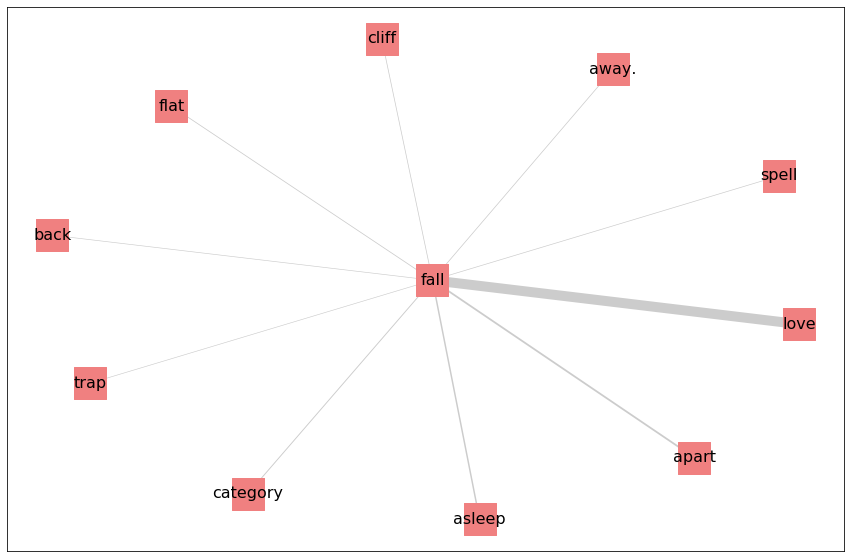

In [296]:
draw_graph(g)

In [165]:
prefix_keys[word][:5]

[('dream', 14.547951169450936),
 ('soon', 12.416025747559084),
 ("n't", 5.965902902742938)]

fever [('dream', 14.547951169450936), ('soon', 12.416025747559084), ("n't", 5.965902902742938)]


In [162]:
[t for t in scored if 'fever' in t[0]]

[(('frantic', 'fever'), 19.344118220262146),
 (('fever', 'dream'), 14.547951169450936),
 (('widescreen', 'fever'), 14.018688041851664),
 (('fever', 'soon'), 12.416025747559084),
 (('comes', 'fever'), 10.71877429191008),
 (('fever', "n't"), 5.965902902742938)]

In [245]:
[t for t in scored if 'marriage' in t[0]]

[(('marriage', 'proposal'), 32.23159057449391),
 (('marriage', 'counselor'), 27.675869206684048),
 (('marriage', 'retreat'), 26.04432087573655),
 (('marriage', 'Troy'), 24.890696677744838),
 (('break', 'marriage'), 24.332600691513623),
 (('deadens', 'marriage'), 18.01791836392334),
 (('divinity', 'marriage'), 18.01791836392334),
 (('eschewing', 'marriage'), 18.01791836392334),
 (('foresaking', 'marriage'), 18.01791836392334),
 (('interfaith', 'marriage'), 18.01791836392334),
 (('marriage', 'Hobbes'), 18.01791836392334),
 (('marriage', 'basher'), 18.01791836392334),
 (('marriage', 'housewifery'), 18.01791836392334),
 (('marriage', 'kimmy'), 18.01791836392334),
 (('primeval', 'marriage'), 18.01791836392334),
 (('marriage', 'Alicia'), 17.571094419076264),
 (('marriage', 'survive'), 16.38680321612455),
 (('marriage', 'She'), 15.664271867329774),
 (('marriage', 'Guilia'), 15.245573386421421),
 (('marriage', 'alcoholism.'), 15.245573386421421),
 (('Stacey', 'marriage'), 14.19932084328233),
 